In [1]:
import pandas as pd
import os
from bs4 import BeautifulSoup
from more_itertools import unique_everseen
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io
import matplotlib.cm as cm
import cv2
from PIL import Image,ImageEnhance
import random
import scipy.io
from skimage import color
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from scipy.misc import imresize
from skimage.filters import rank
from skimage.morphology import square,disk
import cv2
from skimage.segmentation import slic
import warnings
from skimage.transform import rescale
from skimage import feature
import math


In [2]:
def load_images_from_folder(folder):
    images = []
    filenames = []
    image_list={}
    for filename in os.listdir(folder):
        filenames.append(filename)
        img = io.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)  
        if(filename not in image_list):
            image_list[filename] = []
        image_list[filename].append(img)
    return images,filenames,image_list

def get_mask_data(images,image_list,filenames,bounding_box_dir):
    xml_data =[]
    mask_data={}
    mask_data2={}
    box_data = {}
    for i in range(len(images)):
        file = bounding_box_dir + filenames[i][:-4] + '.xml'
        xml =""
        with open(file) as f:
            xml = f.readlines()
            xml = ''.join([line.strip('\t') for line in xml])
            xml_new  = BeautifulSoup(xml,"lxml")
        xml_data.append(xml_new)
        
    for bd_data in xml_data:
        objs = bd_data.findAll('object')
        fname = bd_data.findChild('filename').contents[0]
        boxes_img = np.copy(np.asarray(img_list[fname])[0,:,:,:])
        for obj in objs:
            obj_names = obj.findChildren('name')
            for name_tag in obj_names:
                
                
                blank_img = np.zeros(np.asarray(img_list[fname])[0,:,:,:].shape)
                bbox = obj.findChildren('bndbox')[0]
                xmin = int(bbox.findChildren('xmin')[0].contents[0])
                ymin = int(bbox.findChildren('ymin')[0].contents[0])
                xmax = int(bbox.findChildren('xmax')[0].contents[0])
                ymax = int(bbox.findChildren('ymax')[0].contents[0])
                blank_img[ymin:ymax,xmin:xmax,:] = 1
                boxes_img = cv2.rectangle(boxes_img,(xmin,ymin),(xmax,ymax),(255,0,0),2)
                if(fname[:-4] not in mask_data):
                    mask_data[fname[:-4]] =[]
                    mask_data2[fname[:-4]] =[]
                    box_data[fname[:-4]] =[]
                mask_data[fname[:-4]].append(blank_img)
                box_data[fname[:-4]]=boxes_img
                mask_data2[fname[:-4]].append([xmin,ymin,xmax,ymax])
                
    return mask_data,mask_data2,box_data


In [3]:
params={}
params['distribution_windows']=50000
params['min_width']=10
params['min_height']=10
params['pixelDistance']=8
params['imageBorder']=0.05
params['pascalThreshold'] = 0.5


params['SS'] = {}
params['MS']={}
params['MS']['name'] = 'Multiscale-Saliency';
params['MS']['colortype'] = 'rgb';
params['MS']['filter_size'] = 3;
params['MS']['scale'] = [16,24,32,48,64];
params['MS']['theta'] = [0.43,0.32,0.34,0.35,0.26];
#params['MS']['domain'] = repmat(0.01:0.01:1,5,1);
params['MS']['sizeNeighborhood'] = 7;
#params['MS']bincenters = 0:1:500;
params['MS']['numberBins'] = 500

#params for CC
params['CC'] = {}
params['CC']['domain'] = list(range(100,201,1))
params['CC']['quant'] = np.array([4,8,8])
params['CC']['theta'] = 100
params['CC']['name'] = 'Color-Contrast';
params['CC']['numberBins'] = 200

#params for ED
params['ED'] = {}
params['ED']['name'] = 'Edge-Density';
params['ED']['theta'] = 17;
#params['ED']['domain'] = 1:1:100;
params['ED']['crop_size'] = 200;
params['ED']['pixelDistance'] = 8;
params['ED']['imageBorder'] = 0;
#params['ED']['bincenters'] = 0:0.05:5;
params['ED']['numberBins'] = 100

#params for SS
params['SS']['name'] = 'Superpixels-Straddling';
params['SS']['basis_sigma'] = 0.5;
params['SS']['theta'] = 450;
#params.SS.domain = 200:50:2000;
params['SS']['basis_min_area'] = 200;
params['SS']['pixelDistance'] = 8;
params['SS']['imageBorder'] = 0.05;
#params['SS']['bincenters'] = 0:0.01:1;
params['SS']['numberBins'] = 100


In [4]:
root_dir = 'C:/Users/prath/OneDrive/Documents/IIITH/DIP/Project'
img_dir = os.path.join(root_dir, 'images/')
sample_img_dir = os.path.join(img_dir,'s/')
bounding_box_dir = os.path.join(img_dir,'b/')
images,filenames,img_list = load_images_from_folder(sample_img_dir) #list of images with each image with 3d and filenames of each image
mask_data,mask_data2,boxes_data = get_mask_data(images,img_list,filenames,bounding_box_dir) #mask_data - imgs with mask portion white and rest black and mask_data2 array of xmin,ymin,xmax,ymax

In [5]:
sample_img = plt.imread("004701.jpg")

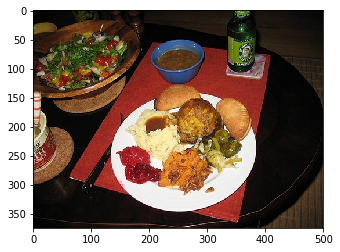

In [6]:
plt.imshow(sample_img)

## Generate uniform windows

In [7]:
def generateWindows_uniform(img,params):
    height,width,_ = img.shape
    total_samples = params['distribution_windows']
    min_width = params['min_width']
    min_height = params['min_height']
    xmin = np.zeros((total_samples,1))
    xmax = np.zeros((total_samples,1))
    ymin = np.zeros((total_samples,1))
    ymax = np.zeros((total_samples,1))
    random.seed(100)
    for i in range(0,total_samples):
        x1 = round(random.random()*(width-1)+1)
        x2 = round(random.random()*(width-1)+1)
        while(abs(x1-x2)+1<min_width):
            x1=round(random.random()*(width-1)+1)
            x2=round(random.random()*(width-1)+1)
        
        y1 = round(random.random()*(height-1)+1)
        y2 = round(random.random()*(height-1)+1)
        while(abs(y1-y2)+1<min_height):
            y1=round(random.random()*(height-1)+1)
            y2=round(random.random()*(height-1)+1)
        xmin[i]=min(x1,x2)
        ymin[i]=min(y1,y2)
        xmax[i]=max(x1,x2)
        ymax[i]=max(y1,y2)
#         print('###########')
#         print(x1)
#         print(x2)
#         print(y1)
#         print(y2)
        
#         print('*************')
#         print(xmin[i])
#         print(ymin[i])
#         print(xmax[i])
#         print(ymax[i])
        
    windows = [xmin,ymin,xmax,ymax]
    return np.asarray(windows)
        

In [8]:
windows = generateWindows_uniform(sample_img,params)

## Generate dense windows

In [9]:
def generateWindows_dense(img,params):
    pixelDistance = params['pixelDistance']
    imageBorder = params['imageBorder']
    height,width,_ = img.shape

    offsetHeight = np.floor(imageBorder * height)
    offsetWidth  = np.floor(imageBorder * width)

    height = int(np.floor(height * (1 - imageBorder)/pixelDistance))
    width  = int(np.floor(width  * (1 - imageBorder)/pixelDistance))

    totalWindows = int(height*width * (height+1) * (width+1)/4)
    
    xmin = np.zeros((totalWindows,1))
    xmax = np.zeros((totalWindows,1))
    ymin = np.zeros((totalWindows,1))
    ymax = np.zeros((totalWindows,1))

    currentWindow = 0

    for x in range(0,width):
        for y in range(0,height):
            for w in range(0,width - x ):
                for h in range(0,height - y):
                    
                    xmin[currentWindow] = x
                    ymin[currentWindow] = y
                    xmax[currentWindow] = x + w - 1
                    ymax[currentWindow] = y + h - 1
                    currentWindow = currentWindow+1
                
    xmin = xmin * pixelDistance + offsetWidth
    xmax = xmax * pixelDistance + offsetWidth
    ymin = ymin * pixelDistance + offsetHeight
    ymax = ymax * pixelDistance + offsetHeight

    windows = [xmin,ymin,xmax,ymax]
    return np.asarray(windows)

## Compute Area of a given box

In [10]:
def computeArea(box):
    
    xmin = box[0]
    ymin = box[1]
    xmax = box[2]
    ymax = box[3]
    if(xmin>xmax or ymin>ymax):
        area = 0
    else:
        area = (xmax-xmin+1)*(ymax-ymin+1)
    return area

## Compute area of intersectin for two boxes/windows

In [11]:
def computeIntersectionArea(box1,box2):
    xmin = max(box1[0],box2[0])
    ymin = max(box1[1],box2[1])
    xmax = max(box1[2],box2[2])
    ymax = max(box1[3],box2[3]) 
    intersection_box = np.asarray([xmin,ymin,xmax,ymax]).reshape((4,1))
    intersection_area = computeArea(intersection_box)
    return intersection_area

### Pascal Score

In [12]:
def computePascalScore(box1,box2):
    intersection_area = computeIntersectionArea(box1,box2)
    pascalScore = intersection_area/(computeArea(box1)+computeArea(box2)-intersection_area)
    return pascalScore

## NMS sampling

In [13]:
def nms_sample(boxes,threshold,maxWindows):
    xmin = boxes[0][0]
    ymin = boxes[0][1]
    xmax = boxes[0][2]
    ymax = boxes[0][3] 
    scores = (boxes[1]).reshape(boxes[1].shape[0],)
    area = (xmax-xmin+1) * (ymax-ymin+1)
    #print(scores.shape)
    indices = np.argsort(scores)
    #print(indices)
    #print('*****')
    pick=[]
    s_list=[]
    while(len(indices)>0):
        last = len(indices)-1
        i = indices[last]
        
        pick.append(i)
        #print(i)
        supress = [last]
        s_list.append(last)
        for pos in range(0,last):
            j = indices[pos]
            
            xx1 = max(xmin[i],xmin[j])
            yy1 = max(ymin[i],ymin[j])
            xx2 = min(xmax[i],xmax[j])
            yy2 = min(ymax[i],ymax[j])
            
            w = max(0,xx2-xx1+1)
            h = max(0,yy2-yy1+1)
            b1 = [xmin[i],ymin[i],xmax[i],ymax[i]]
            b2 = [xmin[j],ymin[j],xmax[j],ymax[j]]
            overlap = computePascalScore(b1,b2)
            #overlap = float(w*h)/area[j]
            #print(overlap)
            if(overlap>=threshold):
                supress.append(pos)
                s_list.append(pos)
        indices = np.delete(indices,supress)
    #print((pick))
    xmin_final=xmin[pick]
    ymin_final=ymin[pick]
    xmax_final=xmax[pick]
    ymax_final=ymax[pick]
    
    boxes_final = [xmin_final,ymin_final,xmax_final,ymax_final]
    return np.asarray(boxes_final),pick,scores
    
    

In [14]:
def runObjectness(img,params,maxWindows=10):
    windows_uniform = generateWindows_uniform(img,params)
    windows_dense = generateWindows_uniform(img,params)
    theta_CC = params['CC']['theta']
    theta_MS = params['MS']['theta']
    theta_SS = params['SS']['theta']
    theta_ED = params['ED']['theta']
    distributionBoxes_CC = computeScores(sample_img,params,'CC',windows_uniform,theta_CC)
    distributionBoxes_MS = MS_score(sample_img,params)
    distributionBoxes_SS = computeSSScore(windows,sample_img,100,5)
    distributionBoxes_ED = edge_density_score(sample_img,params,windows_dense)
    scores = np.zeros((distributionBoxes_MS[0].shape[-1],4))
    scores[:,0] = distributionBoxes_MS[-1]
    scores[:,1] = distributionBoxes_CC[-1]
    scores[:,2] = distributionBoxes_ED[-1]
    scores[:,3] = distributionBoxes_SS[-1]
    scoreBayes = integrateBayes(scores,params)
    distributionBoxes_MS[-1] = scoreBayes
    boxes = nms_sample(distributionBoxes_MS, 0.5, maxWindows)
    #boxes = nms_sample(distributionBoxes,0.5,maxWindows)
    return boxes

In [15]:
def drawboxes(img,boxes):
    
    xmin = (boxes[:,0])
    ymin = (boxes[:,1])
    xmax = (boxes[:,2])
    ymax = (boxes[:,3])
    box_img = np.copy(img)
    scores = boxes[:,4]
    max_score = max(scores)
    base_color = np.array([1,1,1])
    
    for i in range(0,len(xmin)):
        c =  hsv2rgb(base_color*scores[i]/max_score)
        box_img = cv2.rectangle(box_img,(int(xmin[i]),int(ymin[i])),(int(xmax[i]),int(ymax[i])),c,2)
    return box_img
        

In [16]:
def hsv2rgb(hsi):
    h = float(hsi[0])
    s = float(hsi[1])
    v = float(hsi[2])
    h60 = h / 60.0
    h60f = math.floor(h60)
    hi = int(h60f) % 6
    f = h60 - h60f
    p = v * (1 - s)
    q = v * (1 - f * s)
    t = v * (1 - (1 - f) * s)
    r, g, b = 0, 0, 0
    if hi == 0: r, g, b = v, t, p
    elif hi == 1: r, g, b = q, v, p
    elif hi == 2: r, g, b = p, v, t
    elif hi == 3: r, g, b = p, q, v
    elif hi == 4: r, g, b = t, p, v
    elif hi == 5: r, g, b = v, p, q
    r, g, b = int(r * 255), int(g * 255), int(b * 255)
    return [r, g, b]

In [17]:
def demo(img):
    image = plt.imread(img)
    boxes = runObjectness(img,params,10)
    box_img = drawboxes(image,np.asarray(boxes))
    plt.imshow(box_img)
   

In [18]:
def luminance(image):
    n= image.shape[0]
    m= image.shape[1]
    image2 = np.copy(image.reshape(n*m,3))
    for i in range(n*m):
        image2[i][0] = np.abs(0.2125*image2[i][0] + 0.7154*image2[i][1] + 0.0721*image2[i][2])
    image2 = np.delete(image2,0,1)
    image2 = np.delete(image2,0,1)
    image2 = image2.reshape(n,m)
    return image2

## Positive negative images

In [19]:
def generatePosNeg(params):
    root_dir = 'C:/Users/prath/OneDrive/Documents/IIITH/DIP/Project'
    img_dir = os.path.join(root_dir, 'images/')
    sample_img_dir = os.path.join(img_dir,'sample_images/')
    bounding_box_dir = os.path.join(img_dir,'Bounding_box/')
    images,filenames,img_list = load_images_from_folder(sample_img_dir) #list of images with each image with 3d and filenames of each image
    mask_data,mask_data2,boxes_data = get_mask_data(images,img_list,filenames,bounding_box_dir) #mask_data - imgs with mask portion white and rest black and mask_data2 array of xmin,ymin,xmax,ymax
    posneg = []
    
    for i in range(0,len(mask_data2)):
        image = plt.imread(sample_img_dir+filenames[i])
        windows = generateWindows_uniform(image,params)
        windows_num,_ = windows.shape
        posneg[i].append({'examples': windows})
        labels = -1*np.ones((windows_num,1))
        for w in range(0,windows_num):
            for b in range(0,len(mask_data2[filenames[i][:-4]])):
                pascalScore = computePascalScore(mask_data2[filenames[i][:-4]][b], windows[w])
                if(pascalScore>params['pascalThreshold']):
                    labels[w] = 1
                    break
        
        posneg[i].append({'labels': labels})
        posneg[i].append({'img': image})
    return posneg
    

In [20]:
def computeQuantMatrix(imgLAB,bins):
    L = imgLAB[:,:,0]
    a = imgLAB[:,:,1]
    b = imgLAB[:,:,2]
    
    ll = np.minimum(np.floor(L/(100/bins[0])) + 1,bins[0])
    
    aa = np.minimum(np.floor((a+120)/(240/bins[1])) + 1,bins[1])
    bb = np.minimum(np.floor((b+120)/(240/bins[2])) + 1,bins[2])

    Q = (ll-1)* bins[1]*bins[2] + (aa - 1)*bins[2] + bb
    return np.asarray(Q,dtype='uint8')

## CC score

In [21]:
def computeContrastScore(Q,windows,theta):
    
    height,width= Q.shape
    surrBox = np.copy(windows)
    contrast = np.zeros(((windows.shape[1]),1))
    Q2 = np.copy(Q)
    for w in range(0,windows.shape[1]):
        xmin = int(windows[0][w])
        ymin = int(windows[1][w])
        xmax = int(windows[2][w])
        ymax = int(windows[3][w])
        
        num_pixels_inner = abs((xmin-xmax+1)*(ymin-ymax+1))
        
        mask_inner = np.zeros((height,width),dtype='uint8')
        mask_inner[ymin:ymax, xmin:xmax]= 255
        
        
        #plt.imshow(mask_inner)
        H_inner = cv2.calcHist([Q],[0],mask_inner,histSize=[256],ranges=[0,256])
        
        offsetWidth=width*theta/200;
        offsetHeight=height*theta/200;

        xminSurr=round(max(xmin-offsetWidth,0))
        xmaxSurr=round(min(xmax+offsetWidth,width))
        yminSurr=round(max(ymin-offsetHeight,0))
        ymaxSurr=round(min(ymax+offsetHeight,height))
        
        a = Q[yminSurr:ymaxSurr,xminSurr:xmin].flatten()
        b = Q[yminSurr:ymaxSurr,xmax:xmaxSurr].flatten()
        c = Q[yminSurr:ymin,xmin:xmax].flatten()
        d = Q[ymax:ymaxSurr,xmin:xmax].flatten()
        
        outer_r = np.hstack((a,b,c,d))
        
        
        num_pixels_outer = len(outer_r)
        
#         mask_outer = np.zeros((height,width),dtype='uint8')
#         mask_outer[yminSurr:ymaxSurr, xminSurr:xmaxSurr]= 255
        
        H_outer = cv2.calcHist([outer_r],[0],None,histSize=[256],ranges=[0,256])
        
        H_inner2 = np.asarray(H_inner/num_pixels_inner,dtype='float32')
        H_outer2 = np.asarray(H_outer/num_pixels_outer,dtype='float32')
        
        Q2 = cv2.rectangle(Q2,(xminSurr,yminSurr),(xmaxSurr,ymaxSurr),(0,255,0),2)
        Q2 = cv2.rectangle(Q2,(xmin,ymin),(xmax,ymax),(255,0,0),2)
        
        contrast[w] = cv2.compareHist(H_inner2, H_outer2, 1)
        
    
       
    #plt.imshow(Q2)    
    return contrast     
        
        
        

In [22]:
# def compareHistograms(H1,H2):
    

In [23]:
def computeScores(image,params,cue,windows,theta):
    height, width, _ = image.shape
    totalWindows = len(windows)
    imgLab = color.rgb2lab(image)
    quant = params[cue]['quant']
    Q = computeQuantMatrix(imgLab,quant)
    score = computeContrastScore(Q,windows,theta)
    
    boxes = [windows,score]
    return np.asarray(boxes)
    
    
    

## Log likelihood

In [24]:
def deriveLogLikelihood(posneg,theta,params,cue):
    params[cue]['theta'] = theta
    examplePos = np.zeros((len(posneg)*params['distribution_windows'],1))
    exampleNeg = np.zeros((len(posneg)*params['distribution_windows'],1))
    pos = 0
    neg = 0
    for i in range(0,len(posneg)):
        temp = computeScores(posneg[i]['img'],params,'CC',posneg[i]['examples'],theta);
        posneg[i]['scores'] = temp[:,-1]
        indexPositive = np.argwhere(posneg[i]['labels'] == 1)
        examplesPos[pos:pos+len(indexPositive)] = posneg[i]['scores'][indexPositive]
        pos = pos + len(indexPositive)

        indexNegative = np.argwhere(posneg[i]['labels'] == -1)
        examplesNeg[neg:neg+len(indexNegative)] = posneg[i]['scores'][indexNegative]
        neg = neg + len(indexNegative)
        
    examplePos = examplePos[:pos+1]
    exampleNeg = exampleNeg[:,neg+1]
    
    pobj = (pos)/(pos+neg)
    pbg = 1- pobj
    
    posLikelihood = np.histogram(examplesPos,params[cue]['bincenters'])/length(examplesPos) + eps
    negLikelihood = np.histogram(examplesNeg,params[cue]['bincenters'])/length(examplesNeg) + eps
    logTotal = 0;

    for idx in range( 0,length(examplesPos)):
        for binc in range(1,length(params[cue]['bincenters'])):
            if (examplesPos[idx] <= params[cue]['bincenters'][binc]):           
                break            
            
                    
        binc = binc - 1    
        logTotal = logTotal + log((pobj * posLikelihood(binc))/(pobj * posLikelihood(binc) + pbg * negLikelihood(binc) +eps));            
    

    likelihood = [posLikelihood,negLikelihood]
    return likelihood
        
        
        

# MS score

In [25]:
def saliency_map_channel(img,channel,params,scale):
    filter_size = params['MS']['filter_size']
    img = 1.00*img[:,:,channel]
    resized_img = imresize(img,(scale,scale),interp='bilinear')
    f = np.fft.fft2(resized_img)
    filter1 = square(filter_size)
    filter2 = disk(filter_size)
    log_amplitude = np.log(np.absolute(f))/255
    phase = np.angle(f)
    smooth = rank.mean(log_amplitude, selem=filter1)
    spectral_residual = log_amplitude - smooth
    saliency_map = np.absolute(np.fft.ifft(np.exp(spectral_residual +1+ phase)))**2
    saliency_map = rank.mean(saliency_map, selem=filter2)
    return saliency_map    
def sliding_window_compute_score(saliency_map,scale,min_width,min_height,threshold,sal_integral_image,thr_integral_image):
    score_scale = []   
    image_area = scale*scale
    i=0
    for xmin in range(0,scale-min_width):
        for ymin in range(0,scale-min_height):
            for xmax in range(xmin+min_width,scale):
                for ymax in range(ymin+min_height,scale):
                    area = (xmax-xmin)*(ymax-ymin)
                    
                    aval = sal_integral_image[ymin][xmin]+sal_integral_image[ymax][xmax]-sal_integral_image[ymax][xmin]-sal_integral_image[ymin][xmax]
                    athr = thr_integral_image[ymin][xmin]+thr_integral_image[ymax][xmax]-thr_integral_image[ymax][xmin]-thr_integral_image[ymin][xmax]
                    windows = [xmin,ymin,xmax,ymax]
                    score_scale.append([windows,aval*athr/area])                                     
    return score_scale
def retrieve_coordinates(index,scale):
    image_area = scale*scale
    index1 = index%image_area
    index2 = np.floor(index/image_area)
    x1 = index1%scale + 1
    y1 = np.floor(index1/scale)+1
    x2 = index2%scale + 1
    y1 = np.floor(index2/scale)+1
    return x1,y1,x2,y2   
def compute_integral_image(image):  
    image = np.cumsum(image,axis=0)
    image = np.cumsum(image,axis=1)
    pad_image = np.zeros((image.shape[0]+1,image.shape[1]+1))
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            pad_image[i+1][j+1] = image[i][j]
    return pad_image
def MS_score(img,params):
    xmin = [];ymin = [];xmax = [];ymax = [];score = []
    height,width,channels = img.shape
    scales = params['MS']['scale']
    theta = params['MS']['theta']
    min_window_height = params['min_height'] 
    min_window_width = params['min_width']
    distribution_windows = params['distribution_windows']
    filter_size = params['MS']['filter_size']
    xmins=[]
    xmaxs =[]
    ymins=[]
    ymaxs=[]
    scores =[]
    for i in range(len(scales)):
        scale = scales[i]
        threshold = theta[i]
        min_width = int(max(2,np.round(min_window_width*scale/width )))
        min_height = int(max(2,np.round(min_window_height*scale/height)))
        samples = np.round(distribution_windows/(len(scales)*3))
        for j in range(channels):
            saliency_map = saliency_map_channel(img,j,params,scale)
            thr_map = saliency_map >=threshold
            sal_map = np.multiply(saliency_map,thr_map)
            thr_integral_image = compute_integral_image(thr_map)
            sal_integral_image = compute_integral_image(sal_map)
            score_scale = sliding_window_compute_score(saliency_map,scale,min_width,min_height,threshold,sal_integral_image,thr_integral_image)
            index_positives = np.argwhere(np.asarray(score_scale).T[1]>0)
            for i in range(len(index_positives)):
                xmin = int(score_scale[index_positives[i][0]][0][0]*width/scale)
                ymin = int(score_scale[index_positives[i][0]][0][1]*height/scale)
                xmax = int(score_scale[index_positives[i][0]][0][2]*width/scale)
                ymax = int(score_scale[index_positives[i][0]][0][3]*height/scale)
                xmins.append(xmin) 
                ymins.append(ymin)  
                xmaxs.append(xmax)  
                ymaxs.append(ymax)  
                scores.append(score_scale[index_positives[i][0]][1])                
    final_windows = np.asarray([np.asarray(xmins),np.asarray(ymins),np.asarray(xmaxs),np.asarray(ymaxs)])
    boxes = [final_windows,np.asarray(scores)]
    return np.asarray(boxes)

# ED

In [26]:
def compute_scores(image,xmin,ymin,xmax,ymax,windows):
    windows[windows==0] = 1
    score = np.zeros(len(xmin))
    print(len(xmin))
    print(len(ymin))
    print(len(xmax))
    print(len(ymax))
    print(image.shape)
    for i in range(len(xmin)):
        
        score[i] = image[ymax[i][0]][xmax[i][0]]+image[ymin[i][0]][xmin[i][0]]-image[ymin[i][0]][xmax[i][0]] - image[ymax[i][0]][xmin[i][0]]
    return score
def compute_integral_image(I):  
    integralImage = np.cumsum(I,axis=0)
    integralImage = np.cumsum(integralImage,axis=1)
    npad = ((1, 0), (1,0))
    integralImage = np.pad(integralImage, pad_width=npad, mode='constant', constant_values=0)
    return integralImage
def edge_density_score(image,params,windows_dense):
    channels = image.shape[2]
    theta = params['ED']['theta']    
    if channels==3:
        image = luminance(image)
    edge_image = feature.canny(image)
    integral_image = compute_integral_image(edge_image)
    windows = np.copy(windows_dense)
    xmin = (windows[0]).astype(int)
    ymin = (windows[1]).astype(int)
    xmax = (windows[2]).astype(int)
    ymax = (windows[3]).astype(int)
    xmax_inner = (np.round((xmax*(200+theta)/(theta+100) + xmin*theta/(theta+100)+100/(theta+100)-1)/2)).astype(int)
    xmin_inner = (np.round(xmax+xmin-xmax_inner)).astype(int)
    ymax_inner = (np.round((ymax*(200+theta)/(theta+100) + ymin*theta/(theta+100)+100/(theta+100)-1)/2)).astype(int)
    ymin_inner = (np.round(ymax+ymin-ymax_inner)).astype(int)
    score_windows = compute_scores(integral_image,xmin,ymin,xmax,ymax,windows_dense)
    score_inner_windows = compute_scores(integral_image,xmin_inner,ymin_inner,xmax_inner,ymax_inner,windows_dense)
    area_windows = (xmax-xmin+1) * (ymax-ymin+1)
    area_inner_windows = (xmax_inner - xmin_inner +1) * (ymax_inner -ymin_inner +1)
    area_diff = area_windows - area_inner_windows
    area_diff[area_diff==0] = 100000000   
    score = np.zeros((len(xmax),1))
    for i in range(len(score)):
        score[i] = ((xmax[i]-xmax_inner[i]+ymax[i]-ymax_inner[i])*(score_windows[i]-score_inner_windows[i])/area_diff[i])
    boxes = [windows,score]
    return boxes

# SS

(-0.5, 499.5, 374.5, -0.5)

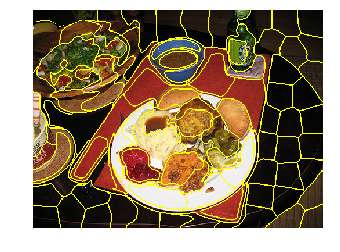

In [27]:
segments = slic(sample_img, n_segments = 100, sigma = 5)
fig = plt.figure("Superpixels -- %d segments" % (100))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(sample_img, segments))
plt.axis("off")

In [28]:
def segmentArea(S):
    tot_seg = np.max(S)
    seg = {}
    for i in range(0,tot_seg):
        seg[i] = {}
        seg[i]['cord'] = np.column_stack(np.where(segments==i))
        seg[i]['area'] = len(seg[i]['cord'])
    return seg
        

In [29]:
def integrateSuperPixels(N):
    tot_seg = np.max(N)
    height, width = N.shape
    integralHist = np.zeros((height+1,width+1,tot_seg))
    for i in range(0,tot_seg):
        superPixelMap = (N-i)==0
        integralHist[:,:,i] = computeIntegralImage(superPixelMap)
    return integralHist

In [30]:
def computeIntegralImage(I):
    integralImage = np.cumsum(I,axis=0)
    integralImage = np.cumsum(integralImage,axis=1)
    npad = ((1, 0), (1,0))
    integralImage = np.pad(integralImage, pad_width=npad, mode='constant', constant_values=0)
    return integralImage

In [31]:
def computeIntegralImageScores(integralImage,windows):

    windows = np.asarray(windows,dtype='int64')
    windows[windows == 0] = 1
    height = integralImage.shape[0]
    index1 = height*windows[2] + (windows[3] + 1)
    index2 = height*(windows[0] - 1) + windows[1]
    index3 = height*(windows[0] - 1) + (windows[3] + 1)
    index4 = height*windows[2] + windows[1]
    
    integralImageFlat = integralImage.flatten()
    score = integralImageFlat[index1] + integralImageFlat[index2] - integralImageFlat[index3] - integralImageFlat[index4]
    return score

In [32]:
def computeSSScore(windows,image,num_segments,sgma):
    segments = slic(image, n_segments = num_segments, sigma = sgma)
    integrateHist = integrateSuperPixels(segments)
    superPixels = segmentArea(segments)
    xmin = (windows[0])
    ymin = (windows[1])
    xmax = (windows[2])
    ymax = (windows[3])
    areaSuperPixels=[]
    for i in range(0,len(superPixels)):
        areaSuperPixels.append(superPixels[i]['area'])
    areaWindows = (xmax - xmin + 1) * (ymax - ymin + 1)
    areaWindows=np.asarray(areaWindows).reshape(-1)
    _,_,n = integrateHist.shape
    intersectionSuperpixels = np.zeros((len(xmin),n))
    for i in range(0,n):
        scores = computeIntegralImageScores(integrateHist[:,:,i],windows) 
        intersectionSuperpixels[:,i] = scores.T
    score = np.ones((windows.shape[1])) - (np.sum(np.minimum(intersectionSuperpixels,np.tile(areaSuperPixels,(windows.shape[1],1)) - intersectionSuperpixels),axis=1)/areaWindows);
    boxes = [windows,score]
    return boxes
    
    

In [33]:
def integrateBayes(params,score):
    MSL = np.genfromtxt("MSlikelihood.csv", delimiter=',')
    EDL = np.genfromtxt("EDlikelihood.csv", delimiter=',')
    SSL = np.genfromtxt("SSlikelihood.csv", delimiter=',')
    CCL = np.genfromtxt("CClikelihood.csv", delimiter=',')
    likelihood = {}
    likelihood['MS'] = MSL
    likelihood['ED'] = EDL
    likelihood['SS'] = SSL
    likelihood['CC'] = CCL
    

    binNumber = {}
    binNumber['MS'] = np.maximum(np.minimum(np.ceil(score[:,0]+0.5),params['MS']['numberBins']),1)
    binNumber['CC'] = np.maximum(np.minimum(np.ceil(score[:,1]*100+0.5),params['CC']['numberBins']),1)
    binNumber['ED'] = np.maximum(np.minimum(np.ceil(score[:,2]*2+0.5),params['ED']['numberBins']),1)
    binNumber['SS'] = np.maximum(np.minimum(np.ceil(score[:,3]*100+0.5),params['SS']['numberBins']),1)
    print(binNumber['MS'].shape)
    pObj = 0.0797
    scoreBayes = np.zeros((score.shape[0],1));
    cues = ['MS','CC','ED','SS']
    for bb_id in range(0,score.shape[0]):

        tempPos = 1;
        tempNeg = 1;

        for cue_id in range(0,4):
            
            tempPos = tempPos * likelihood[cues[cue_id]][0,int(binNumber[cues[cue_id]][bb_id])]
            tempNeg = tempNeg * likelihood[cues[cue_id]][1,int(binNumber[cues[cue_id]][bb_id])]
        

        denominator = (tempPos * pObj + tempNeg * (1-pObj));
        if(denominator):
            scoreBayes[bb_id] = tempPos * pObj /(tempPos * pObj + tempNeg * (1-pObj));
        

    

    scoreBayes = scoreBayes+2.2204e-16;

    return scoreBayes

# DEMO

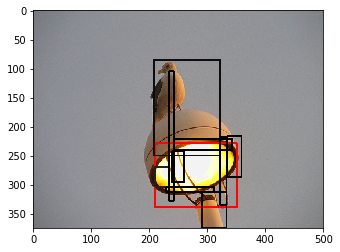

In [34]:
demo("000158.jpg")

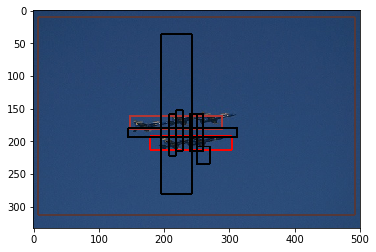

In [35]:
demo("000657.jpg")

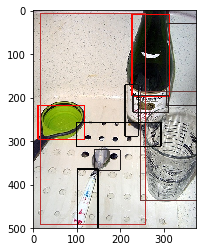

In [37]:
demo("001045.jpg")